#### Necessary Imports

In [7]:
import numpy as np
import pandas as pd
import seaborn as sn
from gensim.models import KeyedVectors
import random
import re
import math
from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

#### Loading Datasets

In [8]:
def read_to_df(file_name):
    labels, input_data = list(), list()
    file = open(file_name, "r", encoding="utf-8")
    file_lines = file.readlines()
    file.close()
    data = {
        "label": [d[0] for d in file_lines],
        "headline": [d[2:] for d in file_lines]
    }
    df = pd.DataFrame(data, columns=["label", "headline"])
    return df

In [9]:
train_df = read_to_df("train.txt")
test_df = read_to_df("test.txt")

* *Reading Stop Words*

In [10]:
file = open("stopwords.txt", "r")
stop_words = file.read().split()
file.close()

#### Loading Word Vectors

In [11]:
word_vectors = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)

C:\Users\Saad Ullah\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


#### Analysing Training Dataset

In [12]:
train_df.head()

,label,headline
0,1,paramount executive snaps up script that begin...
1,1,increasingly paranoid campbell's begins stockp...
2,1,monster truck escapes\n
3,0,sunday roundup\n
4,1,birthday card for david axelrod circling aroun...


In [13]:
train_df.shape

(22892, 2)

* *Plotting to check for skewness*

Text(0.5, 0, 'Labels')

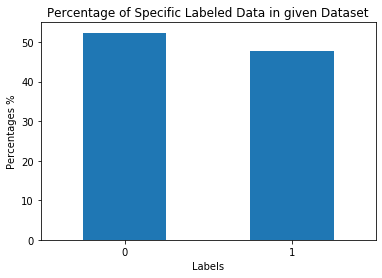

In [14]:
ax = (train_df['label'].value_counts(normalize=True)*100).plot(
        kind="bar", title='Percentage of Specific Labeled Data in given Dataset')
ax.tick_params(axis='x', labelrotation=0)
ax.set_ylabel('Percentages %')
ax.set_xlabel('Labels')

### Preprocessing (Data Cleaning & Word2Vec)

In [15]:
def clean_text(text, stopwords):
    '''
        Cleans Text
        
        Arguments
        ---------
        text : str            
            
        stopwords: list
            Array of shape (x, ), where x is the number of stopwords 
        
        Returns
        --------
        cleaned_text: list
            Array of shape (n, ), where n is the number of words in cleaned text
    '''
    cleaned_text = None

    cleaned_text = re.sub("[^\w]", " ", text) # Removing punctautions
    cleaned_text = cleaned_text.lower() # Converting to lower case
    cleaned_text = cleaned_text.split() # Tokenizing
    cleaned_text = [x for x in cleaned_text if x not in stopwords] # Removing Stopwords
        
    return cleaned_text

def preprocessing(df, word_vectors, stop_words):
    labels, feature_vec = list(), list()
    for i in tqdm(range(len(df))):
        # Cleaning (Stop words, punctuations)
        cleaned_text = clean_text(df["headline"][i], stop_words)
        # Extract vec of all words in a sentence from bin file
        word2vec = np.array([word_vectors[word] for word in cleaned_text if word in word_vectors])
        # Take average of them to get feature vector
        if word2vec.size:
            feature_vec.append(np.mean(word2vec, axis=0))
            labels.append(df["label"][i])
    feature_vec = np.array(feature_vec)
    labels = np.array(labels).astype('int64')
    return labels, feature_vec

In [16]:
train_Y, train_X = preprocessing(train_df, word_vectors, stop_words)

In [17]:
test_Y, test_X = preprocessing(test_df, word_vectors, stop_words)

### Logistic Regression

### KNN

* ***Preprocessing Dataset & Feature Normalization***

In [18]:
def mean_normalize(inp):
    inp = (inp - np.mean(inp))/(np.std(inp))
    return inp

def knn_preprocessor(X, Y):
    '''
        Converts Dataframe to a list of JSON objects, separating 'features' and 'label'
        
        Arguments
        ---------
        df : Pandas Dataframe
            Dataframe of shape (m, n), where m is number of rows and n is the number of columns
            
        n: int
            Number of features
        
        Returns
        -------
        data: list of JSON Objects
            Array of shape (m, ), where m is number of instances and every element is a JSON object with 
            2 keys 'features' that is a NUMPY array of shape (n, ) where n is the number of features and 
            'label' is an integer representing encoded label of that instance
    '''
    data = list()
    m = Y.size
    n = X[0].size
#     # Mean Normalizing Feature Vector
#     X = np.apply_along_axis(mean_normalize, 0, X)
    # Preprocessing
    for i in tqdm(range(m)):
        data.append({'features': X[i], 'label': int(Y[i])})
    return data

* ***Functions to find K Nearest Neighbours using QuickSelect and Order Statistics in O(n)***

In [91]:
def equality_check(arr):
    temp = arr[0]["distance"]
    for x in arr:
        if x["distance"] != temp:
            return False
    return True

def sort_by_pivot(arr, start, end):
    '''
        * Uses the concept of QUICKSELECT and ORDER STATISTICS, and chooses a random element 'pivot' 
        and puts it at a postion 'i', where arr[i] >= arr[j] for all (j < i) and arr[i] <= arr[k] for 
        all (k > i).
        * Or Returns the index of 'pivot-th' smallest element of the 'arr'.
        * Time Complexity = O(n)
        
        Arguments
        ---------
        arr: list
            Array of shape (m, ), where m is the number of elements in the list
        
        start, end: int, int
            Start and end index of arr between which you want to find pivot and sort it accordingly
        
        Returns
        -------
        pivot: int
            Current position of the correctly sorted pivot in the arr. Element at 'pivot' 
            will be the 'pivot-th' smallest element in arr.
    '''
    pivot = random.randint(start,end)
    pivot_val = arr[pivot]['distance']
    i = -1
    j = end
    temp = arr[pivot]
    arr[pivot] = arr[j]
    arr[j] = temp
    i_start = True
    while True:
        if i_start:
            i = i + 1
            if arr[i]['distance'] <= pivot_val:
                i_start = False
        if i == j:
            t = arr[i]
            arr[i] = arr[end]
            arr[end] = t
            break
        if not i_start:
            j = j - 1
        if arr[j]['distance'] > pivot_val and not i_start:
            t = arr[i]
            arr[i] = arr[j]
            arr[j] = t
            i_start = True
    pivot = i
    return pivot

def get_KNN(arr, k):
    '''
        * Uses the concept of QUICKSELECT and ORDER STATISTICS, and returns the 'k' smallest elements from the 'arr'.
        * Time Complexity = O(n)
        
        Arguments
        ---------
        arr: list
            Array of shape (m, ), where m is the number of elements in the list
        
        k: int
            The number of smallest elements that are to be returned.
        
        Returns
        -------
        pivot: int
            Current position of the correctly sorted pivot in the arr. Element at 'pivot' 
            will be the 'pivot-th' smallest element in arr.
    '''
    if k > len(arr):
        return "Invalid Input"
    start = 0
    end = len(arr) - 1
    inf = 0
    while True:
        if start == end or inf == 30:
            return arr[0:k]
        index = sort_by_pivot(arr, start, end)
        if index == (k - 1):
            return arr[0:k]
        elif index < (k - 1):
            start = index + 1
        else:
            end = index - 1
        inf += 1
            
def get_max_label(arr, num_classes):
    '''
        Returns the label that occurs the most in the 'arr'.
        
        Arguments
        ---------
        arr: list
            Array of shape (m, ), where m is the number of elements in the list
        
        num_classes: int
            Number of classes in the dataset
        
        Returns
        -------
        label: int
            The encoded label of the most occured label in the 'arr'
    '''
    label = None
    label_count = [0 for _ in range(num_classes)]
    for x in arr:
        label_count[x['label']] += 1
    # Handling Tie
    if label_count[0] == label_count[1]:
        return {"tie": True}
    label = np.argmax(label_count)
    return {"tie": False, "label": label}

def predict_label(train, d, k, num_classes):
    '''
        Applys KNN Algorithm and predicts the label of 'd' instance
        
        Arguments
        ---------
        train: list of JSON Objects
            Array of shape (m, ), where m is number of training examples and every element is a JSON object with 
            2 keys 'features' that is a NUMPY array of shape (n, ) where n is the number of features and 
            'label' is an integer representing encoded label of that instance
            
        d: JSON Object
            A JSON object with 2 keys, 'features' that is a NUMPY array of shape (n, ) where n is the number of 
            features and 'label' is an integer representing encoded label of that instance
        
        k: int
            The number of smallest elements that are to be returned.
            
        num_classes: int
            Number of classes in the dataset
        
        Returns
        -------
        y_cap: int
            The predicted and encoded label of 'd'
    '''
    y_cap = None
    distances = np.array([
        {
            'distance': (np.dot(x['features'], d['features']) / (np.linalg.norm(x['features'])*np.linalg.norm(d['features']))),
            'label': x['label']
        } 
        for x in train])# O(mn)
    KNN = get_KNN(distances, k) # O(n)
    y_cap = get_max_label(KNN, num_classes) # O(k)
    # Handling Tie
    if y_cap["tie"]:
        KNN = get_KNN(KNN, k-1) # O(k)
        y_cap = get_max_label(KNN, num_classes) # O(k)
    return y_cap["label"]

* ***Testing Function***

In [92]:
def testKNN(train, test, k, num_classes):
    '''
        Applys KNN Algorithm and predicts the labels of all test dataset and builds a confusion matrix
        
        Arguments
        ---------
        train: list of JSON Objects
            Array of shape (m, ), where m is number of training examples and every element is a JSON object with 
            2 keys 'features' that is a NUMPY array of shape (n, ) where n is the number of features and 
            'label' is an integer representing encoded label of that instance
            
        test: list of JSON Objects
            Array of shape (m, ), where m is number of testing instances and every element is a JSON object with 
            2 keys 'features' that is a NUMPY array of shape (n, ) where n is the number of features and 
            'label' is an integer representing encoded label of that instance
        
        k: int
            The number of smallest elements that are to be returned.
            
        num_classes: int
            Number of classes in the dataset
        
        Returns
        -------
        cm: numpy array
            Array of shape (k, k), where k is the number of classes
    '''
    cm = np.zeros((num_classes, num_classes))
    
    for d in tqdm(test):
        pred_c = predict_label(train, d, k, num_classes)
        cm[pred_c][d['label']] += 1
    
    return cm

* ***Processing***

In [93]:
num_classes = 2
knn_train_data = knn_preprocessor(train_X, train_Y)
knn_test_data = knn_preprocessor(test_X, test_Y)

* ***Testing***

In [96]:
k1_cm = testKNN(knn_train_data, knn_test_data, 1, num_classes)

In [99]:
k3_cm = testKNN(knn_train_data, knn_test_data, 3, num_classes)

In [101]:
k5_cm = testKNN(knn_train_data, knn_test_data, 5, num_classes)

In [102]:
k7_cm = testKNN(knn_train_data, knn_test_data, 7, num_classes)

In [94]:
k10_cm = testKNN(knn_train_data, knn_test_data, 10, num_classes)

### Perceptron

#### Evaluation Functions

In [23]:
def evaluation_matrix(cm, classes):
    '''
        Plots confusion matrix and calculates accuracy, precision, recall, f1 score

        Arguments
        ---------
        cm: numpy array
            Array of shape (k, k), where k is the number of classes
            
        classes: list
            Array of encoded labels of shape (c, ), where c is the number of classes
    '''
    df_cm = pd.DataFrame(cm, index = [i for i in classes],
              columns = [i for i in classes])
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap="BuPu")
    plt.show()
    # Calculating Accuracy
    accuracy = np.sum(np.array([cm[i][i] for i in range(len(cm))])) / np.sum(cm)
    print("\n\nAccuracy = %.2f" % (accuracy))
    # Calculating Precision
    precision = cm[0][0]/(cm[0][0]+cm[0][1])
    print("Precision = %.2f" % (precision))
    # Calculating Recall
    recall = cm[0][0]/(cm[0][0]+cm[1][0])
    print("Recall = %.2f" % (recall))
    # Calculating F1 Score
    f1_score = (2*recall*precision)/(recall+precision)
    print("F1 Score = %.2f" % (f1_score))

## Evaluation Report

In [24]:
classes = ["Not Sarcastic", "Sarcastic"]

### Logistic Regression

### KNN

* k = 1

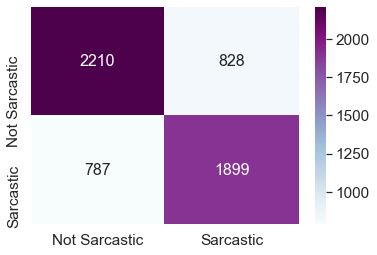



Accuracy = 0.72
Precision = 0.73
Recall = 0.74
F1 Score = 0.73


In [103]:
evaluation_matrix(k1_cm, classes)

* k = 3

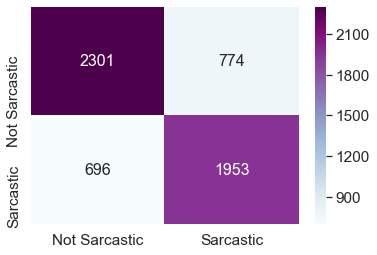



Accuracy = 0.74
Precision = 0.75
Recall = 0.77
F1 Score = 0.76


In [104]:
evaluation_matrix(k3_cm, classes)

* k = 5

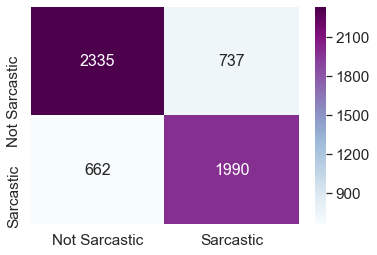



Accuracy = 0.76
Precision = 0.76
Recall = 0.78
F1 Score = 0.77


In [105]:
evaluation_matrix(k5_cm, classes)

* k = 7

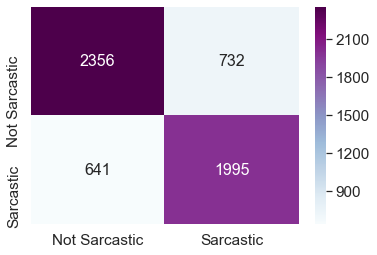



Accuracy = 0.76
Precision = 0.76
Recall = 0.79
F1 Score = 0.77


In [106]:
evaluation_matrix(k7_cm, classes)

* k = 10

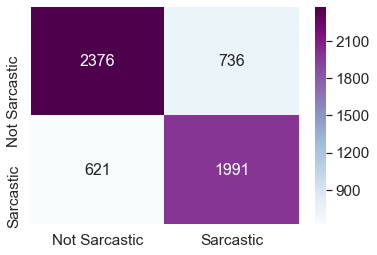



Accuracy = 0.76
Precision = 0.76
Recall = 0.79
F1 Score = 0.78


In [107]:
evaluation_matrix(k10_cm, classes)